In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
# rcParams['figure.figsize'] =15,9
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

/Users/neerajpadarthi/anaconda3/envs/work/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/neerajpadarthi/anaconda3/envs/work/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/neerajpadarthi/anaconda3/envs/work/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/neerajpadarthi/anaconda3/envs/work/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
df = pd.read_csv('formatted_cleanParking.csv')

In [3]:
df.head()

,uuid,asset_id,start_time,end_time,session_type,latitude,longitude,geometry
0,SENSITY-kc-23-40D98DC1-41F8-40EE-BBB8-E44DE41C...,SENSITY-kc-23,2018-08-10 23:33:26.081,2018-08-10 23:33:55.9371,car,39.109786,-94.583482,"{""type"":""Polygon"",""coordinates"":[[[-94.5834598..."
1,SENSITY-kc-22-E5EBBB3A-05E4-4D9C-97CB-26542918...,SENSITY-kc-22,2018-08-10 23:34:58.454,2018-08-10 23:36:08.256733,car,39.109536,-94.580771,"{""type"":""Polygon"",""coordinates"":[[[-94.5807547..."
2,SENSITY-kc-10-C4D472BA-65CA-4D2B-A6C0-9C3981CD...,SENSITY-kc-10,2018-08-10 23:33:40.424,2018-08-10 23:36:25.890125,car,39.094360,-94.583396,"{""type"":""Polygon"",""coordinates"":[[[-94.5834062..."
3,SENSITY-kc-12-4C26D1EC-4CCE-4E9A-87D1-D93149F5...,SENSITY-kc-12,2018-08-10 23:34:44.149,2018-08-10 23:38:53.829785,car,39.095302,-94.583515,"{""type"":""Polygon"",""coordinates"":[[[-94.5835249..."
4,SENSITY-kc-9-CDDB22AD-31F6-4A11-BC94-CCC6602575A1,SENSITY-kc-9,2018-08-10 23:37:38.946,2018-08-10 23:39:01.415632,car,39.092984,-94.583621,"{""type"":""Polygon"",""coordinates"":[[[-94.5836287..."


In [4]:
df.shape

(162124, 8)

In [5]:
df.dropna(axis=0,how='any',inplace=True)

In [6]:
df.drop(columns='geometry',inplace=True)
df.drop(columns='session_type',inplace=True)

In [7]:
df.drop(columns='uuid',inplace=True)

In [8]:
df.drop(columns='latitude',inplace=True)
df.drop(columns='longitude',inplace=True)

In [9]:
df.shape

(62503, 3)

In [10]:
df.rename(columns={'start_time':'start_date','end_time':'end_date'},inplace=True)

In [11]:
df.dtypes

asset_id      object
start_date    object
end_date      object
dtype: object

In [12]:
df['start_date'] = pd.to_datetime(df.start_date,format='%Y/%m/%d').astype('datetime64[s]')
df['end_date'] = pd.to_datetime(df.end_date,format='%Y/%m/%d').astype('datetime64[s]')

In [13]:
df.dtypes

asset_id              object
start_date    datetime64[ns]
end_date      datetime64[ns]
dtype: object

In [14]:
dist_df = df[['asset_id','start_date','end_date']].drop_duplicates()

In [15]:
dist_df.shape

(61811, 3)

In [16]:
temp = pd.to_datetime('2018-08-10',format='%Y\%m\%d')
dist_df.loc[(pd.to_datetime(dist_df.start_date.dt.date) == temp) & (
    dist_df['asset_id']=='SENSITY-kc-2')].sort_values(by=['start_date'],ascending=True)

,asset_id,start_date,end_date
7,SENSITY-kc-2,2018-08-10 23:33:24,2018-08-10 23:47:47
177,SENSITY-kc-2,2018-08-10 23:38:34,2018-08-10 23:47:47
120,SENSITY-kc-2,2018-08-10 23:47:47,2018-08-10 23:50:55
121,SENSITY-kc-2,2018-08-10 23:48:14,2018-08-10 23:50:55
180,SENSITY-kc-2,2018-08-10 23:48:14,2018-08-10 23:53:05
203,SENSITY-kc-2,2018-08-10 23:48:23,2018-08-10 23:53:05
55,SENSITY-kc-2,2018-08-10 23:50:59,2018-08-10 23:53:05
58,SENSITY-kc-2,2018-08-10 23:53:05,2018-08-11 00:01:13
125,SENSITY-kc-2,2018-08-10 23:53:06,2018-08-11 00:01:28


In [17]:
dist_df['start_from_fc']= dist_df.start_date.dt.floor('5min')
dist_df['end_from_fc'] = dist_df.end_date.dt.ceil('5min')

In [18]:
dist_df.isnull().sum()

asset_id         0
start_date       0
end_date         0
start_from_fc    0
end_from_fc      0
dtype: int64

In [19]:
dist_df.dtypes

asset_id                 object
start_date       datetime64[ns]
end_date         datetime64[ns]
start_from_fc    datetime64[ns]
end_from_fc      datetime64[ns]
dtype: object

In [20]:
dist_df.head()

,asset_id,start_date,end_date,start_from_fc,end_from_fc
0,SENSITY-kc-23,2018-08-10 23:33:26,2018-08-10 23:33:55,2018-08-10 23:30:00,2018-08-10 23:35:00
1,SENSITY-kc-22,2018-08-10 23:34:58,2018-08-10 23:36:08,2018-08-10 23:30:00,2018-08-10 23:40:00
2,SENSITY-kc-10,2018-08-10 23:33:40,2018-08-10 23:36:25,2018-08-10 23:30:00,2018-08-10 23:40:00
3,SENSITY-kc-12,2018-08-10 23:34:44,2018-08-10 23:38:53,2018-08-10 23:30:00,2018-08-10 23:40:00
4,SENSITY-kc-9,2018-08-10 23:37:38,2018-08-10 23:39:01,2018-08-10 23:35:00,2018-08-10 23:40:00


In [21]:
temp = pd.to_datetime('2018-08-10',format='%Y\%m\%d')
dist_df.loc[(pd.to_datetime(df.start_date.dt.date) == temp) & (
    dist_df['asset_id']=='SENSITY-kc-2')].sort_values(by=['start_date'],ascending=True)

,asset_id,start_date,end_date,start_from_fc,end_from_fc
7,SENSITY-kc-2,2018-08-10 23:33:24,2018-08-10 23:47:47,2018-08-10 23:30:00,2018-08-10 23:50:00
177,SENSITY-kc-2,2018-08-10 23:38:34,2018-08-10 23:47:47,2018-08-10 23:35:00,2018-08-10 23:50:00
120,SENSITY-kc-2,2018-08-10 23:47:47,2018-08-10 23:50:55,2018-08-10 23:45:00,2018-08-10 23:55:00
121,SENSITY-kc-2,2018-08-10 23:48:14,2018-08-10 23:50:55,2018-08-10 23:45:00,2018-08-10 23:55:00
180,SENSITY-kc-2,2018-08-10 23:48:14,2018-08-10 23:53:05,2018-08-10 23:45:00,2018-08-10 23:55:00
203,SENSITY-kc-2,2018-08-10 23:48:23,2018-08-10 23:53:05,2018-08-10 23:45:00,2018-08-10 23:55:00
55,SENSITY-kc-2,2018-08-10 23:50:59,2018-08-10 23:53:05,2018-08-10 23:50:00,2018-08-10 23:55:00
58,SENSITY-kc-2,2018-08-10 23:53:05,2018-08-11 00:01:13,2018-08-10 23:50:00,2018-08-11 00:05:00
125,SENSITY-kc-2,2018-08-10 23:53:06,2018-08-11 00:01:28,2018-08-10 23:50:00,2018-08-11 00:05:00


In [22]:
n = (dist_df.end_from_fc - dist_df.start_from_fc)
# n,(n.dt.total_seconds())/60
dist_df['diff'] = (n.dt.total_seconds())/60

In [23]:
dist_df.head(50)

,asset_id,start_date,end_date,start_from_fc,end_from_fc,diff
0,SENSITY-kc-23,2018-08-10 23:33:26,2018-08-10 23:33:55,2018-08-10 23:30:00,2018-08-10 23:35:00,5.0
1,SENSITY-kc-22,2018-08-10 23:34:58,2018-08-10 23:36:08,2018-08-10 23:30:00,2018-08-10 23:40:00,10.0
2,SENSITY-kc-10,2018-08-10 23:33:40,2018-08-10 23:36:25,2018-08-10 23:30:00,2018-08-10 23:40:00,10.0
3,SENSITY-kc-12,2018-08-10 23:34:44,2018-08-10 23:38:53,2018-08-10 23:30:00,2018-08-10 23:40:00,10.0
4,SENSITY-kc-9,2018-08-10 23:37:38,2018-08-10 23:39:01,2018-08-10 23:35:00,2018-08-10 23:40:00,5.0
5,SENSITY-kc-14,2018-08-10 23:34:12,2018-08-10 23:39:38,2018-08-10 23:30:00,2018-08-10 23:40:00,10.0
6,SENSITY-kc-18,2018-08-10 23:36:28,2018-08-10 23:40:19,2018-08-10 23:35:00,2018-08-10 23:45:00,10.0
7,SENSITY-kc-2,2018-08-10 23:33:24,2018-08-10 23:47:47,2018-08-10 23:30:00,2018-08-10 23:50:00,20.0
8,SENSITY-kc-12,2018-08-10 23:47:25,2018-08-10 23:47:50,2018-08-10 23:45:00,2018-08-10 23:50:00,5.0
9,SENSITY-kc-21,2018-08-10 23:47:51,2018-08-10 23:49:26,2018-08-10 23:45:00,2018-08-10 23:50:00,5.0


In [24]:
dist_df[dist_df['diff'].isnull()]

,asset_id,start_date,end_date,start_from_fc,end_from_fc,diff


In [25]:
dist_df['slots'] = dist_df['diff']/5
dist_df['slots']=dist_df['slots'].astype('int64')
dist_df['bins'] = dist_df.slots.map( lambda x: np.arange(1,x+1,1) if x > 1.0 else np.arange(1,x+1))

In [26]:
dist_df.head()

,asset_id,start_date,end_date,start_from_fc,end_from_fc,diff,slots,bins
0,SENSITY-kc-23,2018-08-10 23:33:26,2018-08-10 23:33:55,2018-08-10 23:30:00,2018-08-10 23:35:00,5.0,1,[1]
1,SENSITY-kc-22,2018-08-10 23:34:58,2018-08-10 23:36:08,2018-08-10 23:30:00,2018-08-10 23:40:00,10.0,2,"[1, 2]"
2,SENSITY-kc-10,2018-08-10 23:33:40,2018-08-10 23:36:25,2018-08-10 23:30:00,2018-08-10 23:40:00,10.0,2,"[1, 2]"
3,SENSITY-kc-12,2018-08-10 23:34:44,2018-08-10 23:38:53,2018-08-10 23:30:00,2018-08-10 23:40:00,10.0,2,"[1, 2]"
4,SENSITY-kc-9,2018-08-10 23:37:38,2018-08-10 23:39:01,2018-08-10 23:35:00,2018-08-10 23:40:00,5.0,1,[1]


In [26]:
dist_df.dtypes

asset_id                 object
start_date       datetime64[ns]
end_date         datetime64[ns]
start_from_fc    datetime64[ns]
end_from_fc      datetime64[ns]
diff                    float64
slots                     int64
bins                     object
dtype: object

In [27]:
dist_df['start'] = dist_df.start_date.dt.date
dist_df['start'] = pd.to_datetime(dist_df.start,format='%Y\%m\%d')

In [28]:
dist_df.head(5)

,asset_id,start_date,end_date,start_from_fc,end_from_fc,diff,slots,bins,start
0,SENSITY-kc-23,2018-08-10 23:33:26,2018-08-10 23:33:55,2018-08-10 23:30:00,2018-08-10 23:35:00,5.0,1,[1],2018-08-10
1,SENSITY-kc-22,2018-08-10 23:34:58,2018-08-10 23:36:08,2018-08-10 23:30:00,2018-08-10 23:40:00,10.0,2,"[1, 2]",2018-08-10
2,SENSITY-kc-10,2018-08-10 23:33:40,2018-08-10 23:36:25,2018-08-10 23:30:00,2018-08-10 23:40:00,10.0,2,"[1, 2]",2018-08-10
3,SENSITY-kc-12,2018-08-10 23:34:44,2018-08-10 23:38:53,2018-08-10 23:30:00,2018-08-10 23:40:00,10.0,2,"[1, 2]",2018-08-10
4,SENSITY-kc-9,2018-08-10 23:37:38,2018-08-10 23:39:01,2018-08-10 23:35:00,2018-08-10 23:40:00,5.0,1,[1],2018-08-10


In [29]:
def explode(df, lst_cols, fill_value=''):
    if lst_cols and not isinstance(lst_cols, list):
        lst_cols = [lst_cols]
    idx_cols = df.columns.difference(lst_cols)
    lens = df[lst_cols[0]].str.len()
    if (lens > 0).all():
        return pd.DataFrame({
            col:np.repeat(df[col].values, lens)
            for col in idx_cols
        }).assign(**{col:np.concatenate(df[col].values) for col in lst_cols}) \
          .loc[:, df.columns]
    else:
        return pd.DataFrame({
            col:np.repeat(df[col].values, lens)
            for col in idx_cols
        }).assign(**{col:np.concatenate(df[col].values) for col in lst_cols}) \
          .append(df.loc[lens==0, idx_cols]).fillna(fill_value) \
          .loc[:, df.columns]

In [30]:
new_df=explode(dist_df, ['bins'], fill_value='')

In [31]:
new_df.isnull().sum()

asset_id         0
start_date       0
end_date         0
start_from_fc    0
end_from_fc      0
diff             0
slots            0
bins             0
start            0
dtype: int64

In [32]:
new_df[new_df['slots'].isnull()]

,asset_id,start_date,end_date,start_from_fc,end_from_fc,diff,slots,bins,start


In [33]:
new_df['bins'] = (new_df.start_from_fc + pd.to_timedelta(5*(new_df['bins']), unit='m'))
new_df['bins1'] = new_df.bins - pd.to_timedelta(5, unit='m')

In [34]:
new_df.head(100)

,asset_id,start_date,end_date,start_from_fc,end_from_fc,diff,slots,bins,start,bins1
0,SENSITY-kc-23,2018-08-10 23:33:26,2018-08-10 23:33:55,2018-08-10 23:30:00,2018-08-10 23:35:00,5.0,1,2018-08-10 23:35:00,2018-08-10,2018-08-10 23:30:00
1,SENSITY-kc-22,2018-08-10 23:34:58,2018-08-10 23:36:08,2018-08-10 23:30:00,2018-08-10 23:40:00,10.0,2,2018-08-10 23:35:00,2018-08-10,2018-08-10 23:30:00
2,SENSITY-kc-22,2018-08-10 23:34:58,2018-08-10 23:36:08,2018-08-10 23:30:00,2018-08-10 23:40:00,10.0,2,2018-08-10 23:40:00,2018-08-10,2018-08-10 23:35:00
3,SENSITY-kc-10,2018-08-10 23:33:40,2018-08-10 23:36:25,2018-08-10 23:30:00,2018-08-10 23:40:00,10.0,2,2018-08-10 23:35:00,2018-08-10,2018-08-10 23:30:00
4,SENSITY-kc-10,2018-08-10 23:33:40,2018-08-10 23:36:25,2018-08-10 23:30:00,2018-08-10 23:40:00,10.0,2,2018-08-10 23:40:00,2018-08-10,2018-08-10 23:35:00
5,SENSITY-kc-12,2018-08-10 23:34:44,2018-08-10 23:38:53,2018-08-10 23:30:00,2018-08-10 23:40:00,10.0,2,2018-08-10 23:35:00,2018-08-10,2018-08-10 23:30:00
6,SENSITY-kc-12,2018-08-10 23:34:44,2018-08-10 23:38:53,2018-08-10 23:30:00,2018-08-10 23:40:00,10.0,2,2018-08-10 23:40:00,2018-08-10,2018-08-10 23:35:00
7,SENSITY-kc-9,2018-08-10 23:37:38,2018-08-10 23:39:01,2018-08-10 23:35:00,2018-08-10 23:40:00,5.0,1,2018-08-10 23:40:00,2018-08-10,2018-08-10 23:35:00
8,SENSITY-kc-14,2018-08-10 23:34:12,2018-08-10 23:39:38,2018-08-10 23:30:00,2018-08-10 23:40:00,10.0,2,2018-08-10 23:35:00,2018-08-10,2018-08-10 23:30:00
9,SENSITY-kc-14,2018-08-10 23:34:12,2018-08-10 23:39:38,2018-08-10 23:30:00,2018-08-10 23:40:00,10.0,2,2018-08-10 23:40:00,2018-08-10,2018-08-10 23:35:00


In [35]:
 new_df.groupby(['bins1','bins','asset_id']).count()[['start_from_fc']]

start_from_fc
bins1               bins                asset_id                    
2018-08-10 23:30:00 2018-08-10 23:35:00 SENSITY-kc-10              2
                                        SENSITY-kc-12              4
                                        SENSITY-kc-14              2
                                        SENSITY-kc-18              3
                                        SENSITY-kc-2               1
                                        SENSITY-kc-22              1
                                        SENSITY-kc-23              2
                                        SENSITY-kc-8               2
2018-08-10 23:35:00 2018-08-10 23:40:00 SENSITY-kc-10              4
                                        SENSITY-kc-12              4
                                        SENSITY-kc-14              5
                                        SENSITY-kc-18              5
                                        SENSITY-kc-2               2
                                        SENSITY-kc-22              2
                                        SENSITY-kc-5               5
                                        SENSITY-kc-8               2
                                        SENSITY-kc-9               2
2018-08-10 23:40:00 2018-08-10 23:45:00 SENSITY-kc-10              2
                                        SENSITY-kc-12              2
                                        SENSITY-kc-14              4
                                        SENSITY-kc-18              2
                                        SENSITY-kc-2               2
                                        SENSITY-kc-22              1
                                        SENSITY-kc-5               5
                                        SENSITY-kc-8               2
2018-08-10 23:45:00 2018-08-10 23:50:00 SENSITY-kc-10              3
                                        SENSITY-kc-12              2
                                        SENSITY-kc-14              8
                                        SENSITY-kc-2               6
                                        SENSITY-kc-21              4
...                                                              ...
2018-11-26 15:35:00 2018-11-26 15:40:00 SENSITY-kc-11              1
                                        SENSITY-kc-12              2
                                        SENSITY-kc-14              3
                                        SENSITY-kc-15              1
                                        SENSITY-kc-17              1
                                        SENSITY-kc-2               2
                                        SENSITY-kc-23              1
                                        SENSITY-kc-6               3
                                        SENSITY-kc-9               1
2018-11-26 15:40:00 2018-11-26 15:45:00 SENSITY-kc-11              1
                                        SENSITY-kc-12              1
                                        SENSITY-kc-14              2
                                        SENSITY-kc-15              1
                                        SENSITY-kc-2               1
                                        SENSITY-kc-6               2
2018-11-26 15:45:00 2018-11-26 15:50:00 SENSITY-kc-12              1
                                        SENSITY-kc-15              1
                                        SENSITY-kc-2               1
                                        SENSITY-kc-5               1
                                        SENSITY-kc-6               3
                                        SENSITY-kc-9               1
2018-11-26 15:50:00 2018-11-26 15:55:00 SENSITY-kc-10              2
                                        SENSITY-kc-11              1
                                        SENSITY-kc-12              1
                                        SENSITY-kc-5               1
                                        SENSITY-kc-6 

In [35]:
df_5min = new_df.groupby(['bins1','bins','asset_id']).count()[['start_from_fc']].add_suffix('_Count').reset_index()

In [41]:
df_5min

,start_time,end_time,sensor_id,no_of_cars
0,2018-08-10 23:30:00,2018-08-10 23:35:00,SENSITY-kc-10,2
1,2018-08-10 23:30:00,2018-08-10 23:35:00,SENSITY-kc-12,4
2,2018-08-10 23:30:00,2018-08-10 23:35:00,SENSITY-kc-14,2
3,2018-08-10 23:30:00,2018-08-10 23:35:00,SENSITY-kc-2,1
4,2018-08-10 23:30:00,2018-08-10 23:35:00,SENSITY-kc-22,1
5,2018-08-10 23:30:00,2018-08-10 23:35:00,SENSITY-kc-23,2
6,2018-08-10 23:30:00,2018-08-10 23:35:00,SENSITY-kc-8,2
7,2018-08-10 23:35:00,2018-08-10 23:40:00,SENSITY-kc-10,4
8,2018-08-10 23:35:00,2018-08-10 23:40:00,SENSITY-kc-12,4
9,2018-08-10 23:35:00,2018-08-10 23:40:00,SENSITY-kc-14,5


In [42]:
df_5min.rename(columns={'bins1':'start_time','bins':'end_time','asset_id':'sensor_id'
                        ,'start_from_fc_Count':'no_of_cars'}
               ,inplace=True)

In [43]:
df_5min.head()

,start_time,end_time,sensor_id,no_of_cars
0,2018-08-10 23:30:00,2018-08-10 23:35:00,SENSITY-kc-10,2
1,2018-08-10 23:30:00,2018-08-10 23:35:00,SENSITY-kc-12,4
2,2018-08-10 23:30:00,2018-08-10 23:35:00,SENSITY-kc-14,2
3,2018-08-10 23:30:00,2018-08-10 23:35:00,SENSITY-kc-2,1
4,2018-08-10 23:30:00,2018-08-10 23:35:00,SENSITY-kc-22,1


In [208]:
df_5min.loc[df_5min.sensor_id=='SENSITY-kc-17']

,start_time,end_time,sensor_id,no_of_cars
325,2018-08-11 01:50:00,2018-08-11 01:55:00,SENSITY-kc-17,1
337,2018-08-11 01:55:00,2018-08-11 02:00:00,SENSITY-kc-17,1
1482,2018-08-11 10:00:00,2018-08-11 10:05:00,SENSITY-kc-17,1
1494,2018-08-11 10:05:00,2018-08-11 10:10:00,SENSITY-kc-17,1
1506,2018-08-11 10:10:00,2018-08-11 10:15:00,SENSITY-kc-17,1
1518,2018-08-11 10:15:00,2018-08-11 10:20:00,SENSITY-kc-17,1
1530,2018-08-11 10:20:00,2018-08-11 10:25:00,SENSITY-kc-17,1
1542,2018-08-11 10:25:00,2018-08-11 10:30:00,SENSITY-kc-17,1
1554,2018-08-11 10:30:00,2018-08-11 10:35:00,SENSITY-kc-17,1
1566,2018-08-11 10:35:00,2018-08-11 10:40:00,SENSITY-kc-17,1


In [44]:
df_5min.groupby(['sensor_id']).sum()[['no_of_cars']]

,no_of_cars
sensor_id,
SENSITY-kc-1,16804
SENSITY-kc-10,41508
SENSITY-kc-11,31474
SENSITY-kc-12,43434
SENSITY-kc-14,92605
SENSITY-kc-15,41434
SENSITY-kc-17,13224
SENSITY-kc-18,38451
SENSITY-kc-19,10725


In [45]:
df_5min.shape

(300129, 4)

In [46]:
temp = pd.to_datetime('2018-09-05 07:00:00',format='%Y\%m\%d')
df_5min.loc[(df_5min['start_time'] == temp) & (
    df_5min['sensor_id']=='SENSITY-kc-1')].sort_values(by=['start_time'],ascending=True)

,start_time,end_time,sensor_id,no_of_cars


In [209]:
df_tst_5min = df_5min.loc[(df_5min['sensor_id']=='SENSITY-kc-14')  &
                       (df_5min.start_time.dt.date.astype(str) 
                                                                  >= '2018-09-21')
                      ]

In [210]:
df_tst_5min.count()

start_time    15703
end_time      15703
sensor_id     15703
no_of_cars    15703
dtype: int64

In [211]:
df_tst_5min.groupby([df_tst_5min.start_time.dt.date])\
.count()[['start_time']]

,start_time
start_time,
2018-09-21,268
2018-09-22,284
2018-09-23,281
2018-09-24,280
2018-09-25,284
2018-09-26,248
2018-09-27,261
2018-09-28,259
2018-09-29,282


In [231]:
df_tst_5min.head(20)

,start_time,end_time,sensor_id,no_of_cars,start_date,time
98123,2018-09-21 00:00:00,2018-09-21 00:05:00,SENSITY-kc-14,3,2018-09-21,00:00:00
98133,2018-09-21 00:05:00,2018-09-21 00:10:00,SENSITY-kc-14,4,2018-09-21,00:05:00
98143,2018-09-21 00:10:00,2018-09-21 00:15:00,SENSITY-kc-14,4,2018-09-21,00:10:00
98154,2018-09-21 00:15:00,2018-09-21 00:20:00,SENSITY-kc-14,4,2018-09-21,00:15:00
98164,2018-09-21 00:20:00,2018-09-21 00:25:00,SENSITY-kc-14,4,2018-09-21,00:20:00
98174,2018-09-21 00:25:00,2018-09-21 00:30:00,SENSITY-kc-14,4,2018-09-21,00:25:00
98185,2018-09-21 00:30:00,2018-09-21 00:35:00,SENSITY-kc-14,6,2018-09-21,00:30:00
98195,2018-09-21 00:35:00,2018-09-21 00:40:00,SENSITY-kc-14,6,2018-09-21,00:35:00
98205,2018-09-21 00:40:00,2018-09-21 00:45:00,SENSITY-kc-14,5,2018-09-21,00:40:00
98214,2018-09-21 00:45:00,2018-09-21 00:50:00,SENSITY-kc-14,5,2018-09-21,00:45:00


In [229]:
df_tst_5min['start_date']=df_tst_5min.start_time.dt.date
df_tst_5min['time']=df_tst_5min.start_time.dt.time

/Users/neerajpadarthi/anaconda3/envs/work/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [239]:
temp = df_tst_5min.pivot(index='start_date', columns='time', values='no_of_cars')

In [241]:
temp.fillna(0,inplace=True)

In [242]:
temp

time,00:00:00,00:05:00,00:10:00,00:15:00,00:20:00,00:25:00,00:30:00,00:35:00,00:40:00,00:45:00,...,23:10:00,23:15:00,23:20:00,23:25:00,23:30:00,23:35:00,23:40:00,23:45:00,23:50:00,23:55:00
start_date,,,,,,,,,,,,,,,,,,,,,
2018-09-21,3.0,4.0,4.0,4.0,4.0,4.0,6.0,6.0,5.0,5.0,...,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0
2018-09-22,3.0,3.0,3.0,5.0,5.0,6.0,6.0,6.0,6.0,6.0,...,6.0,6.0,6.0,7.0,7.0,8.0,8.0,7.0,7.0,6.0
2018-09-23,6.0,8.0,12.0,0.0,2.0,4.0,1.0,1.0,1.0,1.0,...,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0
2018-09-24,1.0,1.0,0.0,0.0,0.0,0.0,2.0,3.0,4.0,4.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
2018-09-25,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
2018-09-26,4.0,4.0,4.0,4.0,4.0,3.0,3.0,3.0,3.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-09-27,0.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0,1.0,1.0,...,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,7.0
2018-09-28,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
2018-09-29,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,2.0,1.0,1.0,1.0,1.0,1.0,3.0,5.0,1.0,1.0


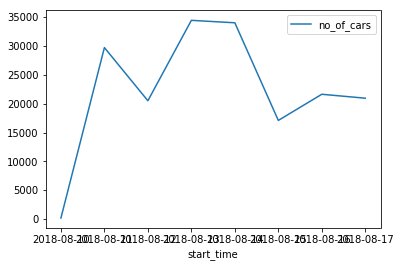

In [46]:
df_5min.loc[
                       (df_5min.start_time.dt.date.astype(str) 
                                                                  <= '2018-08-17')
                      ].groupby([df_5min.start_time.dt.date])\
.sum()[['no_of_cars']].plot()

In [51]:
df_sensor_data = df_5min.loc[(df_5min.start_time.dt.time.astype(str) 
                                                                  > '00:00:00') & (df_5min.start_time.dt.time.astype
                                                                                   (str) 
                                                                  < '13:00:00') &
                       (df_5min.start_time.dt.date.astype(str) 
                                                                  <= '2018-08-25')
                      ].groupby([df_5min['sensor_id']]).sum()[['no_of_cars']]\
.sort_values(by=['no_of_cars']).add_suffix('_Count').reset_index()

In [52]:
df_sensor_data

,sensor_id,no_of_cars_Count
0,SENSITY-kc-19,256
1,SENSITY-kc-17,923
2,SENSITY-kc-1,943
3,SENSITY-kc-7,1142
4,SENSITY-kc-4,1269
5,SENSITY-kc-22,1449
6,SENSITY-kc-21,1460
7,SENSITY-kc-6,2617
8,SENSITY-kc-11,2825
9,SENSITY-kc-15,2942


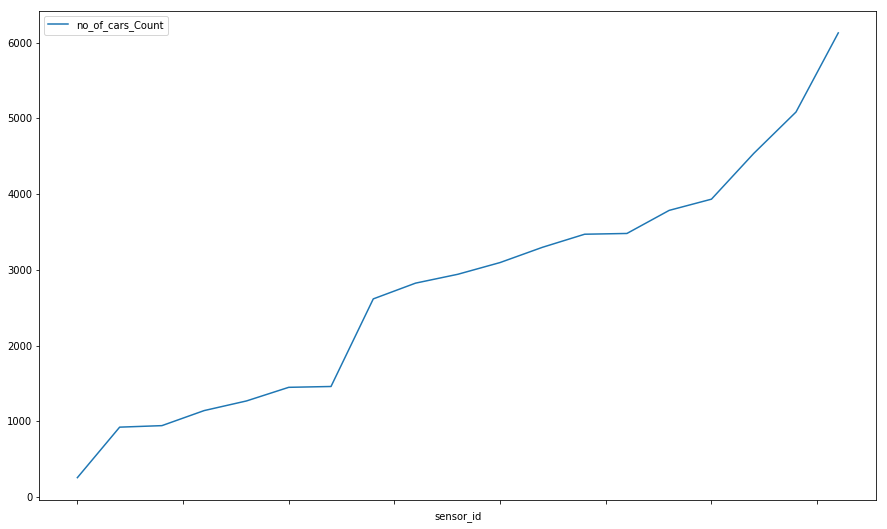

In [53]:
df_sensor_data.set_index('sensor_id').plot(figsize=(15, 9))

In [54]:
df_all_sensors_1stweek = df_5min.groupby(['sensor_id',df_5min.start_time.dt.dayofweek])\
.sum()[['no_of_cars']].add_suffix('_Count').reset_index()

In [55]:
# df_5min['day_of_the_week'] = df_5min.start_time.dt.dayofweek
df_all_sensors_1stweek

,sensor_id,start_time,no_of_cars_Count
0,SENSITY-kc-1,0,1900
1,SENSITY-kc-1,1,2337
2,SENSITY-kc-1,2,2124
3,SENSITY-kc-1,3,3108
4,SENSITY-kc-1,4,1915
5,SENSITY-kc-1,5,2569
6,SENSITY-kc-1,6,2851
7,SENSITY-kc-10,0,4088
8,SENSITY-kc-10,1,5130
9,SENSITY-kc-10,2,6318


In [56]:
df_pivot_sen = df_all_sensors_1stweek.pivot(index='start_time', columns='sensor_id', values='no_of_cars_Count')

In [57]:
df_pivot_sen.fillna(0,inplace=True)

In [58]:
df_pivot_sen

sensor_id,SENSITY-kc-1,SENSITY-kc-10,SENSITY-kc-11,SENSITY-kc-12,SENSITY-kc-14,SENSITY-kc-15,SENSITY-kc-17,SENSITY-kc-18,SENSITY-kc-19,SENSITY-kc-2,SENSITY-kc-21,SENSITY-kc-22,SENSITY-kc-23,SENSITY-kc-4,SENSITY-kc-5,SENSITY-kc-6,SENSITY-kc-7,SENSITY-kc-8,SENSITY-kc-9
start_time,,,,,,,,,,,,,,,,,,,
0,1900,4088,4050,5874,11954,6081,1539,5021,1310,7429,2901,3488,6174,2067,6675,5198,2082,8493,7350
1,2337,5130,4199,6246,12880,6375,2169,5240,1700,7800,3793,3178,7192,2330,6051,5738,2539,9156,7283
2,2124,6318,4658,5093,14029,5776,2007,4983,1036,8598,2978,2986,6590,2463,5747,5822,2437,9500,6094
3,3108,7385,4562,6453,12875,5805,1968,5711,1260,9429,4139,3627,6855,2240,6727,6443,2969,9248,7635
4,1915,5988,4159,6429,13915,6692,2460,5177,1310,9560,3660,4335,7491,1849,7926,7046,2482,9386,7855
5,2569,7088,4445,6792,13148,5220,1464,6569,2179,9600,4504,4848,8462,1476,8536,5776,2859,11185,9212
6,2851,5511,5401,6547,13804,5485,1617,5750,1930,9094,4073,5322,7502,2274,7825,5623,2508,9680,8370


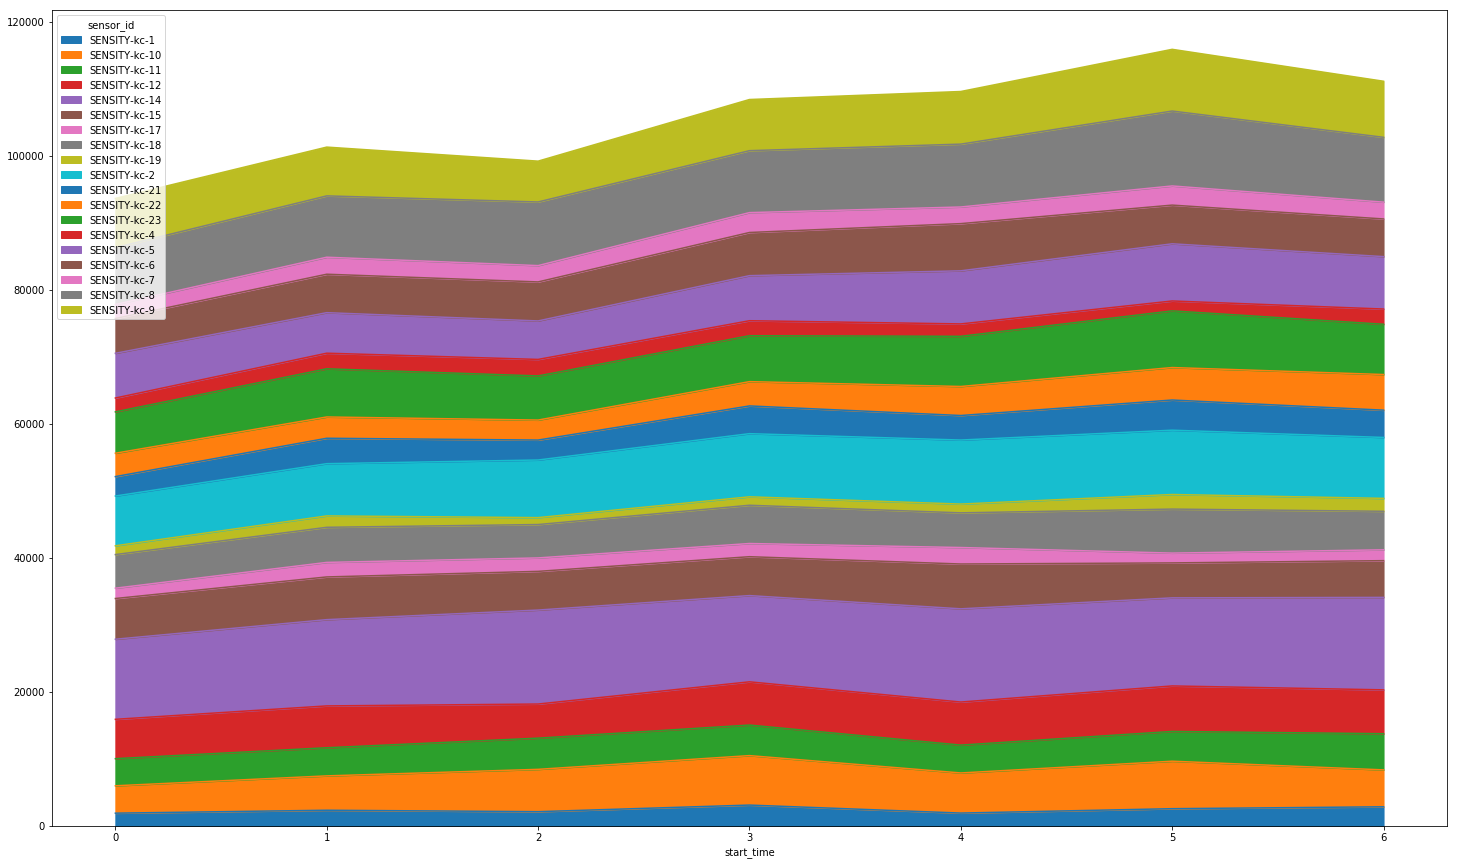

In [59]:
df_pivot_sen.plot(kind='area', 
#              stacked=False,
             figsize=(25, 15), # pass a tuple (x, y) size
             )

In [56]:
df_sensor_1stsensor = df_5min.loc[
                       (df_5min['sensor_id']=='SENSITY-kc-1')
                      ].groupby(['sensor_id',df_5min.start_time.dt.dayofweek])\
.sum()[['no_of_cars']].add_suffix('_Count').reset_index()

In [60]:
df_tst_5min = df_5min.loc[(df_5min['sensor_id']=='SENSITY-kc-14')  &
                       (df_5min.start_time.dt.date.astype(str) 
                                                                  < '2018-09-10')
                      ]

In [61]:
df_tst_5min.count()

start_time    7321
end_time      7321
sensor_id     7321
no_of_cars    7321
dtype: int64

In [62]:
df_tst_5min= df_tst_5min[['start_time','no_of_cars']]
df_tst_5min = df_tst_5min.set_index('start_time')

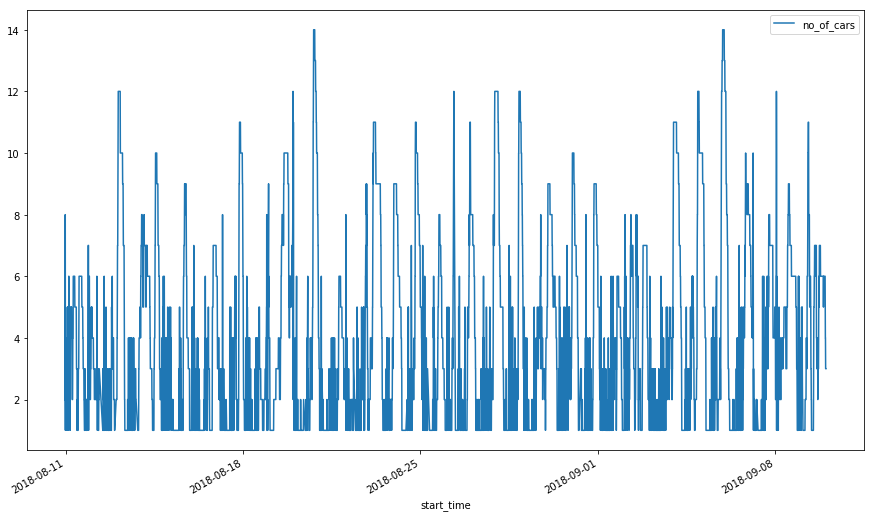

In [63]:
df_tst_5min.plot(figsize=(15,9))

In [196]:
temp_df = df_5min.loc[df_5min['no_of_cars']>=18].groupby(['sensor_id']).count()[['no_of_cars']]

In [197]:
temp_df.reset_index(inplace=True)

In [198]:
temp_df =temp_df.sort_values(by=['no_of_cars'],ascending=False)

In [199]:
temp_df

,sensor_id,no_of_cars
0,SENSITY-kc-14,28
1,SENSITY-kc-9,6


In [77]:
loc_df =df_5min.loc[(df_5min['no_of_cars']>15) & (df_5min['sensor_id']=='SENSITY-kc-14')]\
.sort_values(by=['no_of_cars'],ascending=False)

In [78]:
loc_df['weekday'] = loc_df.start_time.dt.weekday_name

In [79]:
loc_df

,start_time,end_time,sensor_id,no_of_cars,weekday
177623,2018-10-17 02:45:00,2018-10-17 02:50:00,SENSITY-kc-14,18,Wednesday
177515,2018-10-17 02:15:00,2018-10-17 02:20:00,SENSITY-kc-14,18,Wednesday
177749,2018-10-17 03:20:00,2018-10-17 03:25:00,SENSITY-kc-14,18,Wednesday
177731,2018-10-17 03:15:00,2018-10-17 03:20:00,SENSITY-kc-14,18,Wednesday
177713,2018-10-17 03:10:00,2018-10-17 03:15:00,SENSITY-kc-14,18,Wednesday
177695,2018-10-17 03:05:00,2018-10-17 03:10:00,SENSITY-kc-14,18,Wednesday
177677,2018-10-17 03:00:00,2018-10-17 03:05:00,SENSITY-kc-14,18,Wednesday
177659,2018-10-17 02:55:00,2018-10-17 03:00:00,SENSITY-kc-14,18,Wednesday
177641,2018-10-17 02:50:00,2018-10-17 02:55:00,SENSITY-kc-14,18,Wednesday
177263,2018-10-17 01:05:00,2018-10-17 01:10:00,SENSITY-kc-14,18,Wednesday


In [82]:
df_tst_5min.shape

(7321, 1)

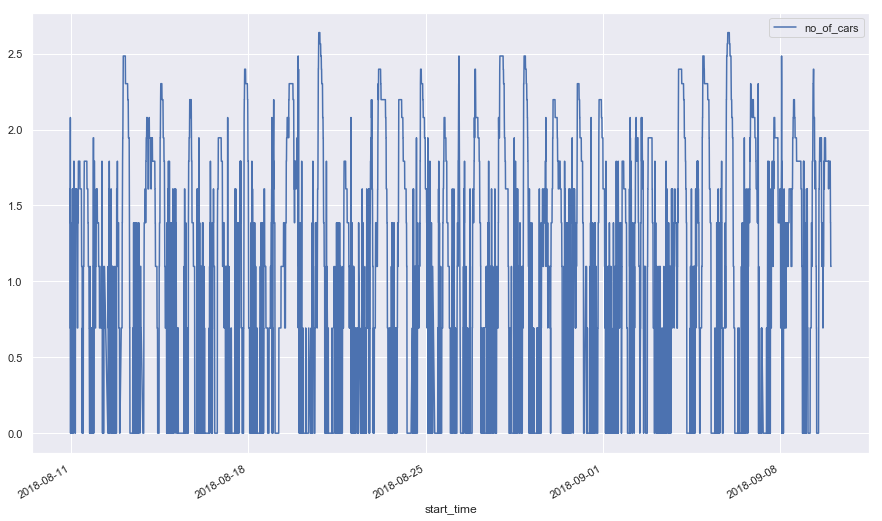

In [83]:
indexedDataset_logScale = np.log(df_tst_5min)
indexedDataset_logScale.plot(figsize=(15,9))

In [84]:
def test_stationarity(timeseries):
    
    movingAverage = timeseries.rolling(window=50).mean()
    movingSTD = timeseries.rolling(window=50).std()
    
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['no_of_cars'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

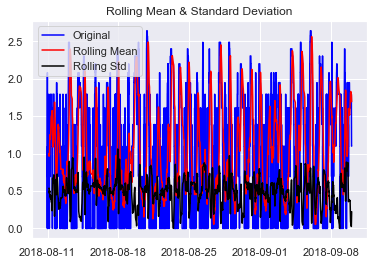

Results of Dickey Fuller Test:
Test Statistic                -1.027998e+01
p-value                        3.801980e-18
#Lags Used                     6.000000e+00
Number of Observations Used    7.314000e+03
Critical Value (5%)           -2.861935e+00
Critical Value (1%)           -3.431244e+00
Critical Value (10%)          -2.566980e+00
dtype: float64


In [85]:
test_stationarity(indexedDataset_logScale)

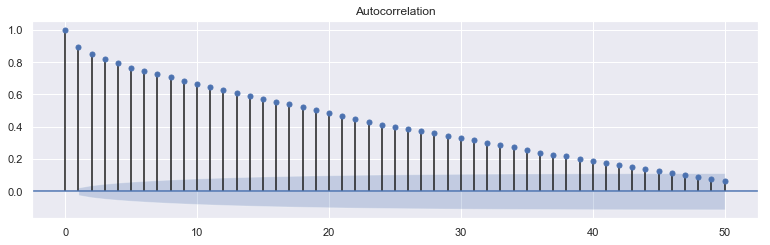

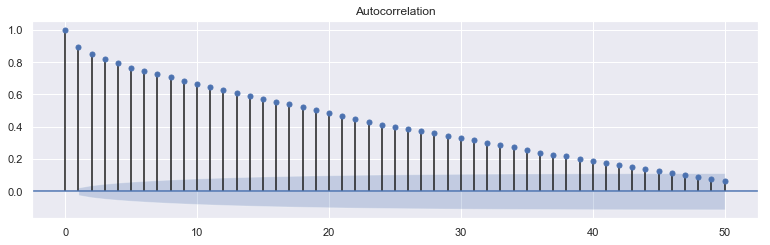

In [86]:
from statsmodels.graphics.tsaplots import plot_acf
fig=plt.figure(figsize=(13,8))
ax1=fig.add_subplot(211)
plot_acf(indexedDataset_logScale,lags=50,ax=ax1)

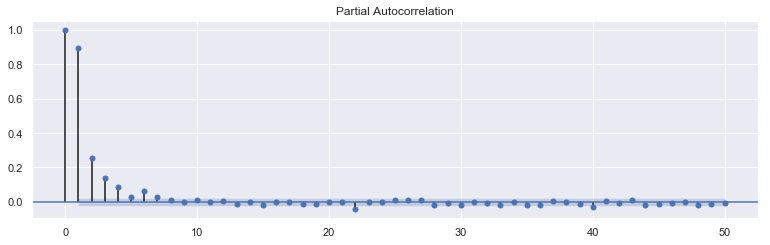

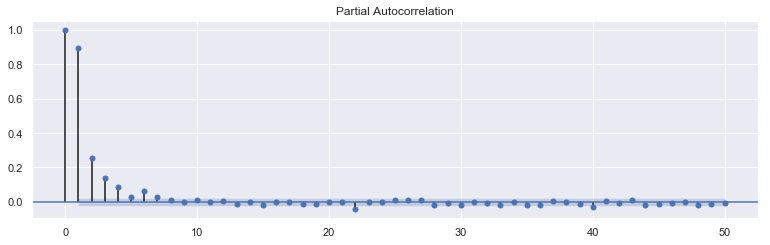

In [87]:
from statsmodels.graphics.tsaplots import plot_pacf
fig=plt.figure(figsize=(13,8))
ax1=fig.add_subplot(211)
plot_pacf(indexedDataset_logScale,lags=50,ax=ax1)

/Users/neerajpadarthi/anaconda3/envs/work/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/neerajpadarthi/anaconda3/envs/work/lib/python3.5/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/Users/neerajpadarthi/anaconda3/envs/work/lib/python3.5/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

Plotting AR model


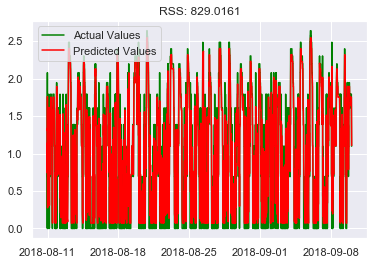

In [89]:
model = ARIMA(indexedDataset_logScale, order=(5,0,0))
results_AR = model.fit(disp=-1)
plt.plot(indexedDataset_logScale, color='green',label='Actual Values')
plt.plot(results_AR.fittedvalues, color='red', label='Predicted Values')
plt.legend(loc='best')
plt.title('RSS: %.4f'%sum((results_AR.fittedvalues - indexedDataset_logScale['no_of_cars'])**2))
print('Plotting AR model')

In [90]:
X = indexedDataset_logScale.values
X1= df_tst_5min.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
size1 = int(len(X1) * 0.66)
train1, test1 = X1[0:size1], X1[size1:len(X1)]
print(train.shape)
print(test.shape)

(4831, 1)
(2490, 1)


In [ ]:
stepwise_model.fit(train)
stepwise_model.aic()

In [ ]:
future_forecast = stepwise_model.predict(n_periods=37)

In [95]:
n = sm.tsa.SARIMAX(indexedDataset_logScale, order=(4,0,1), seasonal_order=(4,0,0,10)).fit(disp=False)
print(n.aic)
j = n.predict(2038,2063)
plt.plot(indexedDataset_logScale.values)
plt.plot(j)

/Users/neerajpadarthi/anaconda3/envs/work/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/neerajpadarthi/anaconda3/envs/work/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


4896.966538234719


Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x1206c4b70> (for post_execute):


ValueError: ordinal must be >= 1

ValueError: ordinal must be >= 1

Test MSE: 0.765


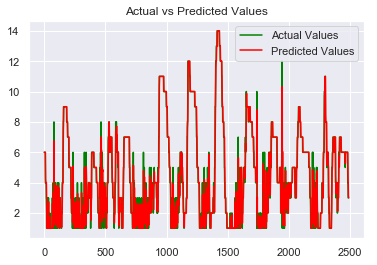

In [97]:
history = [x for x in train1]
predictions = list()
for t in range(len(test1)):
	model =  ARIMA(history, order=(4,1,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test1[t]
	history.append(obs)
# 	print('predicted=%f, expected=%f' % (yhat, obs))
error = (mean_squared_error(test1, predictions))
print('Test MSE: %.3f' % error)
# plot
plt.plot(test1, color='green',label='Actual Values')
plt.plot(predictions, color='red', label='Predicted Values')
plt.legend(loc='best')
plt.title('Actual vs Predicted Values')
plt.show(block=False)

In [ ]:
39.0997° N, 94.5786° W

In [421]:
import datetime
import forecastio

date = datetime.datetime(2019,3,23)
forecast = forecastio.load_forecast('09557fe0d55f9b17d789a228d096a104', 39.0968, -94.5838, units="us")

In [422]:
hourly = forecast.hourly()

In [553]:
hourly.data[0].d

{'apparentTemperature': 60.77,
 'cloudCover': 1,
 'dewPoint': 42.33,
 'humidity': 0.51,
 'icon': 'cloudy',
 'ozone': 360.84,
 'precipIntensity': 0,
 'precipProbability': 0,
 'pressure': 1017.06,
 'summary': 'Overcast',
 'temperature': 60.77,
 'time': 1553374800,
 'uvIndex': 2,
 'visibility': 10,
 'windBearing': 166,
 'windGust': 11.83,
 'windSpeed': 10.48}

In [426]:
attributes = ["summary","time","temperature"]
times = []
data = {}
for attr in attributes:
    data[attr] = []
start = datetime.datetime(2018, 9, 19)
for offset in range(1, 67):
    print(start+datetime.timedelta(offset))
    forecast = forecastio.load_forecast('09557fe0d55f9b17d789a228d096a104', 39.0968, -94.5838, time=start+datetime.timedelta(offset), units="us")
    h = forecast.hourly()
    d = h.data
    for p in d:
        times.append(p.time)
        for attr in attributes:
            data[attr].append(p.d[attr])

2018-09-20 00:00:00
2018-09-21 00:00:00
2018-09-22 00:00:00
2018-09-23 00:00:00
2018-09-24 00:00:00
2018-09-25 00:00:00
2018-09-26 00:00:00
2018-09-27 00:00:00
2018-09-28 00:00:00
2018-09-29 00:00:00
2018-09-30 00:00:00
2018-10-01 00:00:00
2018-10-02 00:00:00
2018-10-03 00:00:00
2018-10-04 00:00:00
2018-10-05 00:00:00
2018-10-06 00:00:00
2018-10-07 00:00:00
2018-10-08 00:00:00
2018-10-09 00:00:00
2018-10-10 00:00:00
2018-10-11 00:00:00
2018-10-12 00:00:00
2018-10-13 00:00:00
2018-10-14 00:00:00
2018-10-15 00:00:00
2018-10-16 00:00:00
2018-10-17 00:00:00
2018-10-18 00:00:00
2018-10-19 00:00:00
2018-10-20 00:00:00
2018-10-21 00:00:00
2018-10-22 00:00:00
2018-10-23 00:00:00
2018-10-24 00:00:00
2018-10-25 00:00:00
2018-10-26 00:00:00
2018-10-27 00:00:00
2018-10-28 00:00:00
2018-10-29 00:00:00
2018-10-30 00:00:00
2018-10-31 00:00:00
2018-11-01 00:00:00
2018-11-02 00:00:00
2018-11-03 00:00:00
2018-11-04 00:00:00
2018-11-05 00:00:00
2018-11-06 00:00:00
2018-11-07 00:00:00
2018-11-08 00:00:00


In [180]:
df = pd.DataFrame(data, index=times)
df.head()

,summary,temperature,time
2017-06-21 05:00:00,Partly Cloudy,77.34,1498021200
2017-06-21 06:00:00,Clear,77.23,1498024800
2017-06-21 07:00:00,Clear,75.78,1498028400
2017-06-21 08:00:00,Clear,74.85,1498032000
2017-06-21 09:00:00,Clear,74.04,1498035600


In [135]:
df.shape

(1415, 2)

In [181]:
df['2017-07-27']

,summary,temperature,time
2017-07-27 00:00:00,Humid and Mostly Cloudy,78.83,1501113600
2017-07-27 01:00:00,Light Rain,77.65,1501117200
2017-07-27 02:00:00,Light Rain,76.74,1501120800
2017-07-27 03:00:00,Rain,75.76,1501124400
2017-07-27 04:00:00,Rain,73.98,1501128000
2017-07-27 05:00:00,Heavy Rain,73.53,1501131600
2017-07-27 06:00:00,Rain,73.86,1501135200
2017-07-27 07:00:00,Rain,73.61,1501138800
2017-07-27 08:00:00,Heavy Rain,73.60,1501142400
2017-07-27 09:00:00,Heavy Rain,73.77,1501146000


In [250]:
time = datetime.datetime(2018, 9, 27, 0, 0, 0)
print(time)

2018-09-27 00:00:00


In [286]:
for x in np.arange(0,10, 1):
    print(time+ pd.to_timedelta(x,unit='d'))

2018-11-11 00:00:00
2018-11-12 00:00:00
2018-11-13 00:00:00
2018-11-14 00:00:00
2018-11-15 00:00:00
2018-11-16 00:00:00
2018-11-17 00:00:00
2018-11-18 00:00:00
2018-11-19 00:00:00
2018-11-20 00:00:00


In [272]:
for x in np.arange(0,1440, 5):
    print(time+ pd.to_timedelta(x, unit='m'))

2018-09-27 00:00:00
2018-09-27 00:05:00
2018-09-27 00:10:00
2018-09-27 00:15:00
2018-09-27 00:20:00
2018-09-27 00:25:00
2018-09-27 00:30:00
2018-09-27 00:35:00
2018-09-27 00:40:00
2018-09-27 00:45:00
2018-09-27 00:50:00
2018-09-27 00:55:00
2018-09-27 01:00:00
2018-09-27 01:05:00
2018-09-27 01:10:00
2018-09-27 01:15:00
2018-09-27 01:20:00
2018-09-27 01:25:00
2018-09-27 01:30:00
2018-09-27 01:35:00
2018-09-27 01:40:00
2018-09-27 01:45:00
2018-09-27 01:50:00
2018-09-27 01:55:00
2018-09-27 02:00:00
2018-09-27 02:05:00
2018-09-27 02:10:00
2018-09-27 02:15:00
2018-09-27 02:20:00
2018-09-27 02:25:00
2018-09-27 02:30:00
2018-09-27 02:35:00
2018-09-27 02:40:00
2018-09-27 02:45:00
2018-09-27 02:50:00
2018-09-27 02:55:00
2018-09-27 03:00:00
2018-09-27 03:05:00
2018-09-27 03:10:00
2018-09-27 03:15:00
2018-09-27 03:20:00
2018-09-27 03:25:00
2018-09-27 03:30:00
2018-09-27 03:35:00
2018-09-27 03:40:00
2018-09-27 03:45:00
2018-09-27 03:50:00
2018-09-27 03:55:00
2018-09-27 04:00:00
2018-09-27 04:05:00


In [301]:
attributes = ["start_time"]
data = {}
for attr in attributes:
    data[attr] = []

In [363]:
temp_data=[]
time = datetime.datetime(2018, 9, 20, 0, 0, 0)
print('starting',time)
for x in np.arange(0,67,1):
#     print(time+ pd.to_timedelta(x,unit='d'))
    time=time+ pd.DateOffset(1)
    for y in np.arange(0,1440, 5):
#         print(time+ pd.to_timedelta(y, unit='m'))
        val=time+ pd.to_timedelta(y, unit='m')
        temp_data.append(val)

starting 2018-09-20 00:00:00


In [364]:
df_start_time = pd.DataFrame(temp_data)
df_start_time.head()

,0
0,2018-09-21 00:00:00
1,2018-09-21 00:05:00
2,2018-09-21 00:10:00
3,2018-09-21 00:15:00
4,2018-09-21 00:20:00


In [365]:
df_start_time.rename(columns={0:'start_time'},inplace=True)

In [366]:
df_start_time

,start_time
0,2018-09-21 00:00:00
1,2018-09-21 00:05:00
2,2018-09-21 00:10:00
3,2018-09-21 00:15:00
4,2018-09-21 00:20:00
5,2018-09-21 00:25:00
6,2018-09-21 00:30:00
7,2018-09-21 00:35:00
8,2018-09-21 00:40:00
9,2018-09-21 00:45:00


In [367]:
df_tst_5min

,start_time,end_time,sensor_id,no_of_cars,start_date,time
98123,2018-09-21 00:00:00,2018-09-21 00:05:00,SENSITY-kc-14,3,2018-09-21,00:00:00
98133,2018-09-21 00:05:00,2018-09-21 00:10:00,SENSITY-kc-14,4,2018-09-21,00:05:00
98143,2018-09-21 00:10:00,2018-09-21 00:15:00,SENSITY-kc-14,4,2018-09-21,00:10:00
98154,2018-09-21 00:15:00,2018-09-21 00:20:00,SENSITY-kc-14,4,2018-09-21,00:15:00
98164,2018-09-21 00:20:00,2018-09-21 00:25:00,SENSITY-kc-14,4,2018-09-21,00:20:00
98174,2018-09-21 00:25:00,2018-09-21 00:30:00,SENSITY-kc-14,4,2018-09-21,00:25:00
98185,2018-09-21 00:30:00,2018-09-21 00:35:00,SENSITY-kc-14,6,2018-09-21,00:30:00
98195,2018-09-21 00:35:00,2018-09-21 00:40:00,SENSITY-kc-14,6,2018-09-21,00:35:00
98205,2018-09-21 00:40:00,2018-09-21 00:45:00,SENSITY-kc-14,5,2018-09-21,00:40:00
98214,2018-09-21 00:45:00,2018-09-21 00:50:00,SENSITY-kc-14,5,2018-09-21,00:45:00


In [368]:
merged_df=pd.merge(df_start_time, df_tst_5min,on='start_time', how='outer')

In [369]:
merged_df.head(50)

,start_time,end_time,sensor_id,no_of_cars,start_date,time
0,2018-09-21 00:00:00,2018-09-21 00:05:00,SENSITY-kc-14,3.0,2018-09-21,00:00:00
1,2018-09-21 00:05:00,2018-09-21 00:10:00,SENSITY-kc-14,4.0,2018-09-21,00:05:00
2,2018-09-21 00:10:00,2018-09-21 00:15:00,SENSITY-kc-14,4.0,2018-09-21,00:10:00
3,2018-09-21 00:15:00,2018-09-21 00:20:00,SENSITY-kc-14,4.0,2018-09-21,00:15:00
4,2018-09-21 00:20:00,2018-09-21 00:25:00,SENSITY-kc-14,4.0,2018-09-21,00:20:00
5,2018-09-21 00:25:00,2018-09-21 00:30:00,SENSITY-kc-14,4.0,2018-09-21,00:25:00
6,2018-09-21 00:30:00,2018-09-21 00:35:00,SENSITY-kc-14,6.0,2018-09-21,00:30:00
7,2018-09-21 00:35:00,2018-09-21 00:40:00,SENSITY-kc-14,6.0,2018-09-21,00:35:00
8,2018-09-21 00:40:00,2018-09-21 00:45:00,SENSITY-kc-14,5.0,2018-09-21,00:40:00
9,2018-09-21 00:45:00,2018-09-21 00:50:00,SENSITY-kc-14,5.0,2018-09-21,00:45:00


In [370]:
merged_df.fillna(0,inplace=True)

In [371]:
merged_df.groupby([merged_df.start_time.dt.date])\
.count()[['start_time']]

,start_time
start_time,
2018-09-21,288
2018-09-22,288
2018-09-23,288
2018-09-24,288
2018-09-25,288
2018-09-26,288
2018-09-27,288
2018-09-28,288
2018-09-29,288


In [387]:
merged_df.loc[(merged_df.start_date==0) & (merged_df.start_time.dt.date.astype('str')=='2018-10-04')]

,start_time,end_time,sensor_id,no_of_cars,start_date,time
3744,2018-10-04 00:00:00,0,0,0.0,0,0
3745,2018-10-04 00:05:00,0,0,0.0,0,0
3794,2018-10-04 04:10:00,0,0,0.0,0,0
3795,2018-10-04 04:15:00,0,0,0.0,0,0
3796,2018-10-04 04:20:00,0,0,0.0,0,0
3797,2018-10-04 04:25:00,0,0,0.0,0,0
3798,2018-10-04 04:30:00,0,0,0.0,0,0
3799,2018-10-04 04:35:00,0,0,0.0,0,0
3800,2018-10-04 04:40:00,0,0,0.0,0,0
3801,2018-10-04 04:45:00,0,0,0.0,0,0


In [376]:
merged_df.head()

,start_time,end_time,sensor_id,no_of_cars,start_date,time
0,2018-09-21 00:00:00,2018-09-21 00:05:00,SENSITY-kc-14,3.0,2018-09-21,00:00:00
1,2018-09-21 00:05:00,2018-09-21 00:10:00,SENSITY-kc-14,4.0,2018-09-21,00:05:00
2,2018-09-21 00:10:00,2018-09-21 00:15:00,SENSITY-kc-14,4.0,2018-09-21,00:10:00
3,2018-09-21 00:15:00,2018-09-21 00:20:00,SENSITY-kc-14,4.0,2018-09-21,00:15:00
4,2018-09-21 00:20:00,2018-09-21 00:25:00,SENSITY-kc-14,4.0,2018-09-21,00:20:00


In [388]:
merged_df.to_csv('mergedDf.csv')

In [427]:
df = pd.DataFrame(data, index=times)
df.reset_index(inplace=True)
df.rename(columns={'index':'start_time'},inplace=True)

In [432]:
df.head(3)

,start_time,summary,temperature,time
0,2018-09-20 05:00:00,Clear,80.38,1537419600
1,2018-09-20 06:00:00,Clear,79.23,1537423200
2,2018-09-20 07:00:00,Clear,78.45,1537426800


In [434]:
print(df.start_time[0])

2018-09-20 05:00:00


In [431]:
dist_df['bins'] = dist_df.slots.map( lambda x: np.arange(1,x+1,1) if x > 1.0 else np.arange(1,x+1))cfgvhbnj,m./

SyntaxError: invalid syntax (<ipython-input-431-d3cc97dacbb1>, line 1)

In [430]:
np.arange(0,60,5)
# + pd.to_timedelta(y, unit='m')

array([ 0,  5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55])

In [444]:
for x in np.arange(0,60,5):
    print((df.start_time[0]+pd.to_timedelta(x, unit='m')))

2018-09-20 05:00:00
2018-09-20 05:05:00
2018-09-20 05:10:00
2018-09-20 05:15:00
2018-09-20 05:20:00
2018-09-20 05:25:00
2018-09-20 05:30:00
2018-09-20 05:35:00
2018-09-20 05:40:00
2018-09-20 05:45:00
2018-09-20 05:50:00
2018-09-20 05:55:00


In [450]:
df['orig']=df.start_time.map(lambda x: x+pd.to_timedelta(np.arange(0,60,5), unit='m'))

In [453]:
df.dtypes

start_time     datetime64[ns]
summary                object
temperature           float64
time                    int64
orig                   object
dtype: object

In [475]:
print(list([df.orig[0][0],df.orig[0][1],df.orig[0][2],df.orig[0][3],df.orig[0][4],\
           df.orig[0][5],df.orig[0][6],df.orig[0][7],df.orig[0][8],df.orig[0][9],\
           df.orig[0][10],df.orig[0][11]]))

[Timestamp('2018-09-20 05:00:00'), Timestamp('2018-09-20 05:05:00'), Timestamp('2018-09-20 05:10:00'), Timestamp('2018-09-20 05:15:00'), Timestamp('2018-09-20 05:20:00'), Timestamp('2018-09-20 05:25:00'), Timestamp('2018-09-20 05:30:00'), Timestamp('2018-09-20 05:35:00'), Timestamp('2018-09-20 05:40:00'), Timestamp('2018-09-20 05:45:00'), Timestamp('2018-09-20 05:50:00'), Timestamp('2018-09-20 05:55:00')]


In [485]:
df['time_range']=df.orig.apply(lambda x: list([x[0],x[1],x[2],x[3],\
                             x[4],x[5],x[6],x[7],\
                             x[8],x[9],x[10],x[11]]))

In [488]:
df.drop(columns={'orig'},inplace=True)

In [489]:
df.head()

,start_time,summary,temperature,time,time_range
0,2018-09-20 05:00:00,Clear,80.38,1537419600,"[2018-09-20 05:00:00, 2018-09-20 05:05:00, 201..."
1,2018-09-20 06:00:00,Clear,79.23,1537423200,"[2018-09-20 06:00:00, 2018-09-20 06:05:00, 201..."
2,2018-09-20 07:00:00,Clear,78.45,1537426800,"[2018-09-20 07:00:00, 2018-09-20 07:05:00, 201..."
3,2018-09-20 08:00:00,Clear,78.09,1537430400,"[2018-09-20 08:00:00, 2018-09-20 08:05:00, 201..."
4,2018-09-20 09:00:00,Clear,77.13,1537434000,"[2018-09-20 09:00:00, 2018-09-20 09:05:00, 201..."


In [490]:
temp_df=explode(df, ['time_range'], fill_value='')

In [494]:
temp_df['start_time']=temp_df.time_range

In [496]:
temp_df.drop(columns={'time_range'},inplace=True)

In [498]:
temp_df

,start_time,summary,temperature,time
0,2018-09-20 05:00:00,Clear,80.38,1537419600
1,2018-09-20 05:05:00,Clear,80.38,1537419600
2,2018-09-20 05:10:00,Clear,80.38,1537419600
3,2018-09-20 05:15:00,Clear,80.38,1537419600
4,2018-09-20 05:20:00,Clear,80.38,1537419600
5,2018-09-20 05:25:00,Clear,80.38,1537419600
6,2018-09-20 05:30:00,Clear,80.38,1537419600
7,2018-09-20 05:35:00,Clear,80.38,1537419600
8,2018-09-20 05:40:00,Clear,80.38,1537419600
9,2018-09-20 05:45:00,Clear,80.38,1537419600


In [509]:
final_merged_df=pd.merge(merged_df,temp_df, on='start_time', how='outer')

In [510]:
final_merged_df.head()

,start_time,end_time,sensor_id,no_of_cars,summary,temperature,time
0,2018-09-21 00:00:00,2018-09-21 00:05:00,SENSITY-kc-14,3.0,Clear,87.95,1.537488e+09
1,2018-09-21 00:05:00,2018-09-21 00:10:00,SENSITY-kc-14,4.0,Clear,87.95,1.537488e+09
2,2018-09-21 00:10:00,2018-09-21 00:15:00,SENSITY-kc-14,4.0,Clear,87.95,1.537488e+09
3,2018-09-21 00:15:00,2018-09-21 00:20:00,SENSITY-kc-14,4.0,Clear,87.95,1.537488e+09
4,2018-09-21 00:20:00,2018-09-21 00:25:00,SENSITY-kc-14,4.0,Clear,87.95,1.537488e+09


In [511]:
final_merged_df.groupby([final_merged_df.start_time.dt.date])\
.count()[['start_time']]

,start_time
start_time,
2018-09-20,228
2018-09-21,288
2018-09-22,288
2018-09-23,288
2018-09-24,288
2018-09-25,288
2018-09-26,288
2018-09-27,288
2018-09-28,288


In [521]:
final_merged_df.loc[pd.to_datetime(final_merged_df.start_time.dt.date)=='2018-10-30']

,start_time,end_time,sensor_id,no_of_cars,summary,temperature,time
11232,2018-10-30 00:00:00,2018-10-30 00:05:00,SENSITY-kc-14,9.0,NaN,NaN,NaN
11233,2018-10-30 00:05:00,2018-10-30 00:10:00,SENSITY-kc-14,9.0,NaN,NaN,NaN
11234,2018-10-30 00:10:00,2018-10-30 00:15:00,SENSITY-kc-14,9.0,NaN,NaN,NaN
11235,2018-10-30 00:15:00,2018-10-30 00:20:00,SENSITY-kc-14,9.0,NaN,NaN,NaN
11236,2018-10-30 00:20:00,2018-10-30 00:25:00,SENSITY-kc-14,9.0,NaN,NaN,NaN
11237,2018-10-30 00:25:00,2018-10-30 00:30:00,SENSITY-kc-14,9.0,NaN,NaN,NaN
11238,2018-10-30 00:30:00,2018-10-30 00:35:00,SENSITY-kc-14,9.0,NaN,NaN,NaN
11239,2018-10-30 00:35:00,2018-10-30 00:40:00,SENSITY-kc-14,9.0,NaN,NaN,NaN
11240,2018-10-30 00:40:00,2018-10-30 00:45:00,SENSITY-kc-14,9.0,NaN,NaN,NaN
11241,2018-10-30 00:45:00,2018-10-30 00:50:00,SENSITY-kc-14,9.0,NaN,NaN,NaN


In [518]:
final_merged_df.loc[11232]

start_time     2018-10-30 00:00:00
end_time       2018-10-30 00:05:00
sensor_id            SENSITY-kc-14
no_of_cars                       9
summary                        NaN
temperature                    NaN
time                           NaN
Name: 11232, dtype: object

In [572]:
final_merged_df.loc[final_merged_df.temperature.isna()].groupby([final_merged_df.start_time.dt.date]).count()

,start_time,end_time,sensor_id,no_of_cars,summary,temperature,time
start_time,,,,,,,
2018-10-29,48,48,48,48,0,0,0
2018-10-30,108,108,108,108,0,0,0
2018-11-04,12,12,12,12,0,0,0
2018-11-11,12,12,12,12,0,0,0
2018-11-12,12,12,12,12,0,0,0
2018-11-25,216,216,216,216,0,0,0
2018-11-26,288,288,288,288,0,0,0


In [546]:
df.groupby([df.start_time.dt.date])\
.count()[['start_time']]

,start_time
start_time,
2018-09-20,19
2018-09-21,24
2018-09-22,24
2018-09-23,24
2018-09-24,24
2018-09-25,24
2018-09-26,24
2018-09-27,24
2018-09-28,24


In [547]:
df.loc[pd.to_datetime(df.start_time.dt.date)=='2018-10-30']

,start_time,summary,temperature,time,time_range
951,2018-10-30 02:00:00,Clear,62.37,1540864800,"[2018-10-30 02:00:00, 2018-10-30 02:05:00, 201..."
952,2018-10-30 03:00:00,Clear,61.67,1540868400,"[2018-10-30 03:00:00, 2018-10-30 03:05:00, 201..."
953,2018-10-30 04:00:00,Clear,61.50,1540872000,"[2018-10-30 04:00:00, 2018-10-30 04:05:00, 201..."
954,2018-10-30 06:00:00,Clear,62.09,1540879200,"[2018-10-30 06:00:00, 2018-10-30 06:05:00, 201..."
955,2018-10-30 08:00:00,Clear,61.40,1540886400,"[2018-10-30 08:00:00, 2018-10-30 08:05:00, 201..."
956,2018-10-30 10:00:00,Clear,61.01,1540893600,"[2018-10-30 10:00:00, 2018-10-30 10:05:00, 201..."
957,2018-10-30 12:00:00,Clear,59.83,1540900800,"[2018-10-30 12:00:00, 2018-10-30 12:05:00, 201..."
958,2018-10-30 16:00:00,Overcast,64.97,1540915200,"[2018-10-30 16:00:00, 2018-10-30 16:05:00, 201..."
959,2018-10-30 17:00:00,Overcast,65.95,1540918800,"[2018-10-30 17:00:00, 2018-10-30 17:05:00, 201..."
960,2018-10-30 18:00:00,Overcast,67.55,1540922400,"[2018-10-30 18:00:00, 2018-10-30 18:05:00, 201..."


In [568]:
attributes = ["summary","time","temperature"]
times = []
data = {}
for attr in attributes:
    data[attr] = []
start = datetime.datetime(2018, 10, 29)
for offset in range(0, 2):
    print(start+datetime.timedelta(offset))
    forecast = forecastio.load_forecast('09557fe0d55f9b17d789a228d096a104', 39.0968, -94.5838, time=start+datetime.timedelta(offset), units="us")
    h = forecast.hourly()
    d = h.data
    for p in d:
        times.append(p.time)
#         print(times)
        for attr in attributes:
            data[attr].append(p.d[attr])

2018-10-29 00:00:00
2018-10-30 00:00:00


In [569]:
zdf = pd.DataFrame(data, index=times)
zdf.head(50)

,summary,temperature,time
2018-10-29 05:00:00,Clear,45.37,1540789200
2018-10-29 06:00:00,Clear,43.66,1540792800
2018-10-29 07:00:00,Clear,42.54,1540796400
2018-10-29 08:00:00,Clear,41.39,1540800000
2018-10-29 09:00:00,Clear,42.32,1540803600
2018-10-29 10:00:00,Clear,42.79,1540807200
2018-10-29 11:00:00,Clear,43.15,1540810800
2018-10-29 12:00:00,Clear,42.33,1540814400
2018-10-29 13:00:00,Clear,41.28,1540818000
2018-10-29 14:00:00,Clear,47.79,1540821600


In [575]:
final_merged_df=final_merged_df.loc[pd.to_datetime(final_merged_df.start_time.dt.date)>='2018-09-21']

In [599]:
final_merged_df.isna().sum()

start_time     0
end_time       0
sensor_id      0
no_of_cars     0
summary        0
temperature    0
dtype: int64

In [602]:
final_merged_df.summary.value_counts()

Clear            10644
Overcast          4968
Mostly Cloudy     1656
Partly Cloudy     1128
Light Rain         396
Rain               348
Foggy              120
Heavy Rain          24
Light Snow          12
Name: summary, dtype: int64

In [585]:
final_merged_df.temperature.fillna(final_merged_df.temperature.mean(),inplace=True)

/Users/neerajpadarthi/anaconda3/envs/work/lib/python3.5/site-packages/pandas/core/generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [598]:
final_merged_df.summary.fillna(final_merged_df.summary.mode()[0],inplace=True)

/Users/neerajpadarthi/anaconda3/envs/work/lib/python3.5/site-packages/pandas/core/generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [595]:
final_merged_df.drop(columns={'time'},inplace=True)

/Users/neerajpadarthi/anaconda3/envs/work/lib/python3.5/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [601]:
final_merged_df.groupby([final_merged_df.start_time.dt.date])\
.count()[['start_time']]

,start_time
start_time,
2018-09-21,288
2018-09-22,288
2018-09-23,288
2018-09-24,288
2018-09-25,288
2018-09-26,288
2018-09-27,288
2018-09-28,288
2018-09-29,288


In [603]:
final_merged_df.corr()

,no_of_cars,temperature
no_of_cars,1.000000,0.185059
temperature,0.185059,1.000000


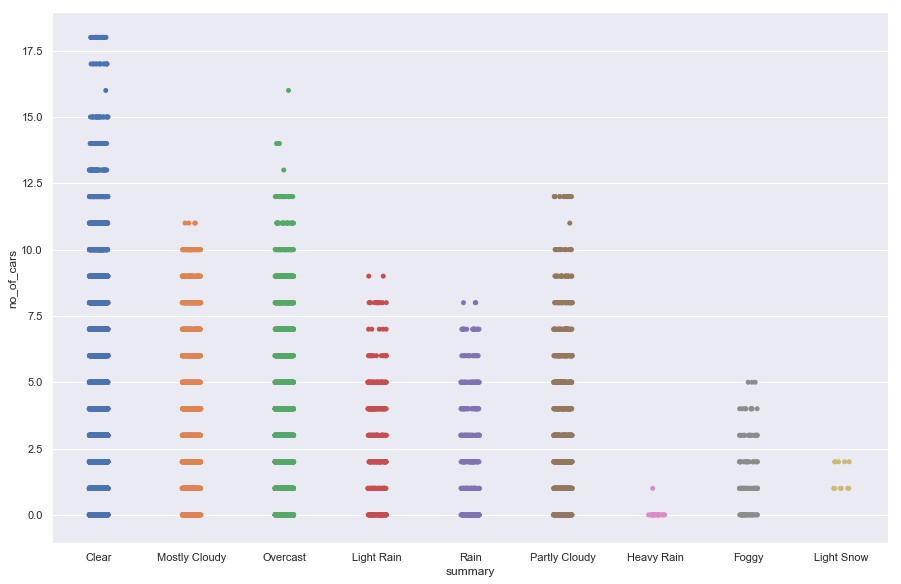

In [622]:
plt.figure(figsize=(16, 12))
g=sns.catplot(x="summary", y="no_of_cars",  data=final_merged_df)
g.fig.set_size_inches(15,9)

In [612]:
sns.set(rc={'figure.figsize':(15,9)})

In [624]:
final_merged_df.to_csv('parking_formatted.csv')

In [7]:
final_merged_df = pd.read_csv('parking_formatted.csv')

In [11]:
final_merged_df['start_time'] = pd.to_datetime(final_merged_df.start_time,format='%Y/%m/%d').astype('datetime64[s]')

In [12]:
final_merged_df.dtypes

start_time     datetime64[ns]
no_of_cars              int64
summary                object
temperature           float64
dtype: object

In [8]:
final_merged_df.head()

,start_time,no_of_cars,summary,temperature
0,2018-09-21 00:00:00,3,Clear,87.95
1,2018-09-21 00:05:00,4,Clear,87.95
2,2018-09-21 00:10:00,4,Clear,87.95
3,2018-09-21 00:15:00,4,Clear,87.95
4,2018-09-21 00:20:00,4,Clear,87.95


In [13]:
df_tst_merged_5min= final_merged_df[['start_time','no_of_cars']]
df_tst_merged_5min = df_tst_merged_5min.set_index('start_time')

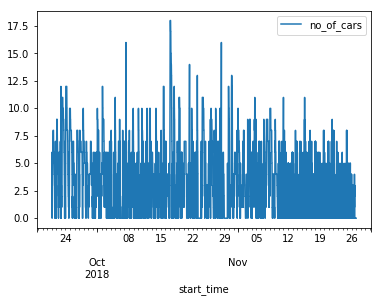

In [14]:
df_tst_merged_5min.plot()

/Users/neerajpadarthi/anaconda3/envs/work/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


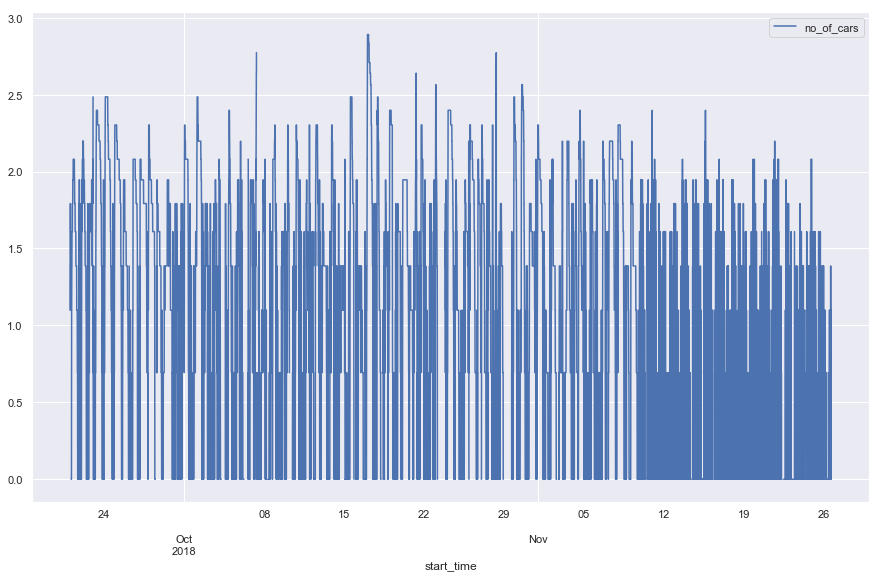

In [636]:
indexedDataset_logScale = np.log(df_tst_merged_5min)
indexedDataset_logScale.plot(figsize=(15,9))

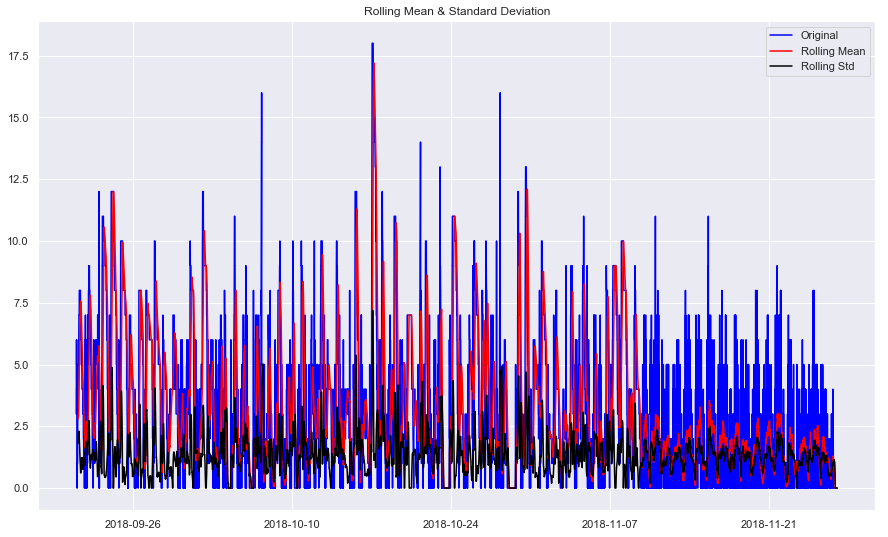

Results of Dickey Fuller Test:
Test Statistic                -1.322481e+01
p-value                        9.851008e-25
#Lags Used                     3.700000e+01
Number of Observations Used    1.925800e+04
Critical Value (5%)           -2.861690e+00
Critical Value (1%)           -3.430690e+00
Critical Value (10%)          -2.566850e+00
dtype: float64


In [640]:
test_stationarity(df_tst_merged_5min)

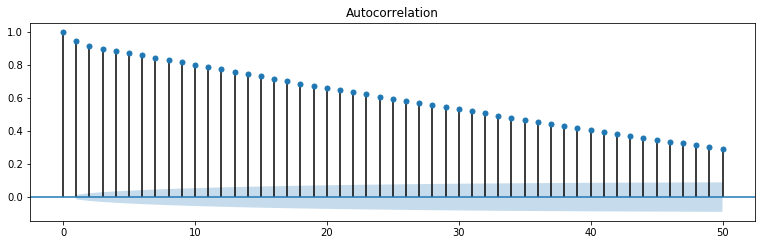

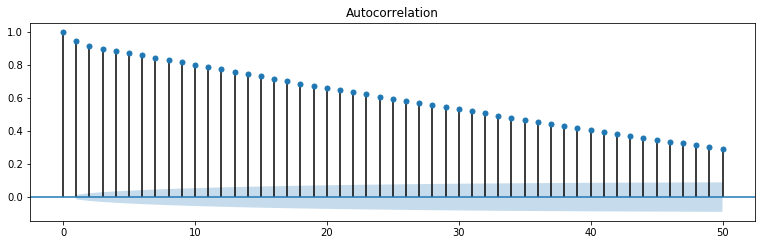

In [15]:
from statsmodels.graphics.tsaplots import plot_acf
fig=plt.figure(figsize=(13,8))
ax1=fig.add_subplot(211)
plot_acf(df_tst_merged_5min,lags=50,ax=ax1)

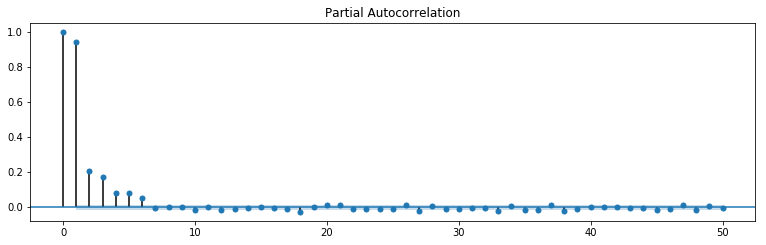

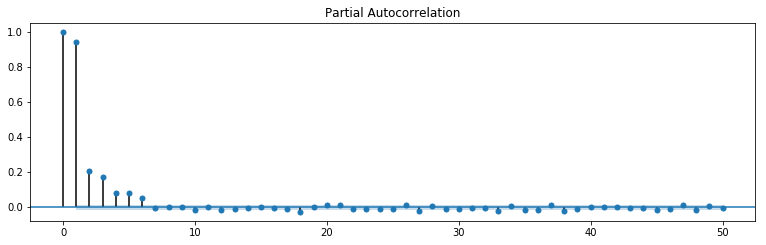

In [18]:
from statsmodels.graphics.tsaplots import plot_pacf
fig=plt.figure(figsize=(13,8))
ax1=fig.add_subplot(211)
plot_pacf(df_tst_merged_5min,lags=50,ax=ax1)

In [21]:
# X = indexedDataset_logScale.values
X1= df_tst_merged_5min.values
# size = int(len(X) * 0.66)
# train, test = X[0:size], X[size:len(X)]
size1 = int(len(X1) * 0.66)
train1, test1 = X1[0:size1], X1[size1:len(X1)]
# print(train.shape)
# print(test.shape)

/Users/neerajpadarthi/anaconda3/envs/work/lib/python3.5/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/Users/neerajpadarthi/anaconda3/envs/work/lib/python3.5/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/Users/neerajpadarthi/anaconda3/envs/work/lib/python3.5/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tupl

Test MSE: 1.489


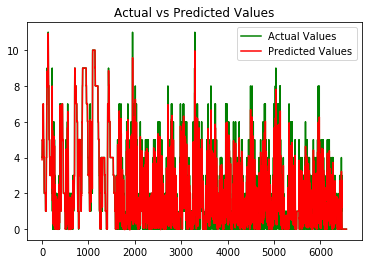

In [22]:
history = [x for x in train1]
predictions = list()
for t in range(len(test1)):
	model =  ARIMA(history, order=(4,1,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test1[t]
	history.append(obs)
# 	print('predicted=%f, expected=%f' % (yhat, obs))
error = (mean_squared_error(test1, predictions))
print('Test MSE: %.3f' % error)
# plot
plt.plot(test1, color='green',label='Actual Values')
plt.plot(predictions, color='red', label='Predicted Values')
plt.legend(loc='best')
plt.title('Actual vs Predicted Values')
plt.show(block=False)

In [25]:
from fbprophet import Prophet
import logging

logging.getLogger().setLevel(logging.ERROR)

In [28]:
dft = df_tst_merged_5min.reset_index()
dft.columns = ['ds', 'y']
dft.head()

,ds,y
0,2018-09-21 00:00:00,3
1,2018-09-21 00:05:00,4
2,2018-09-21 00:10:00,4
3,2018-09-21 00:15:00,4
4,2018-09-21 00:20:00,4


In [31]:
size1 = int(len(X1) * 0.66)
train1, test1 = dft[0:size1], dft[size1:len(X1)]

In [78]:
prediction_size = 300
train_df = dft[:-prediction_size]

In [79]:
len(train_df)

18996

In [80]:
m = Prophet()
m.fit(train_df)

/Users/neerajpadarthi/anaconda3/envs/work/lib/python3.5/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [81]:
future = m.make_future_dataframe(periods=prediction_size, freq = "5Min")
forecast = m.predict(future)
forecast.head()

,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yhat
0,2018-09-21 00:00:00,5.189031,5.189031,5.189031,1.903737,9.312419,0.403618,0.403618,0.403618,0.340931,0.340931,0.340931,0.0,0.0,0.0,0.062687,0.062687,0.062687,5.592649
1,2018-09-21 00:05:00,5.189029,5.189029,5.189029,2.079259,9.073643,0.416891,0.416891,0.416891,0.354153,0.354153,0.354153,0.0,0.0,0.0,0.062738,0.062738,0.062738,5.605920
2,2018-09-21 00:10:00,5.189028,5.189028,5.189028,2.254905,9.557251,0.430204,0.430204,0.430204,0.367417,0.367417,0.367417,0.0,0.0,0.0,0.062787,0.062787,0.062787,5.619232
3,2018-09-21 00:15:00,5.189026,5.189026,5.189026,2.075241,9.143906,0.443489,0.443489,0.443489,0.380654,0.380654,0.380654,0.0,0.0,0.0,0.062835,0.062835,0.062835,5.632515
4,2018-09-21 00:20:00,5.189024,5.189024,5.189024,2.401674,9.050540,0.456675,0.456675,0.456675,0.393793,0.393793,0.393793,0.0,0.0,0.0,0.062882,0.062882,0.062882,5.645699


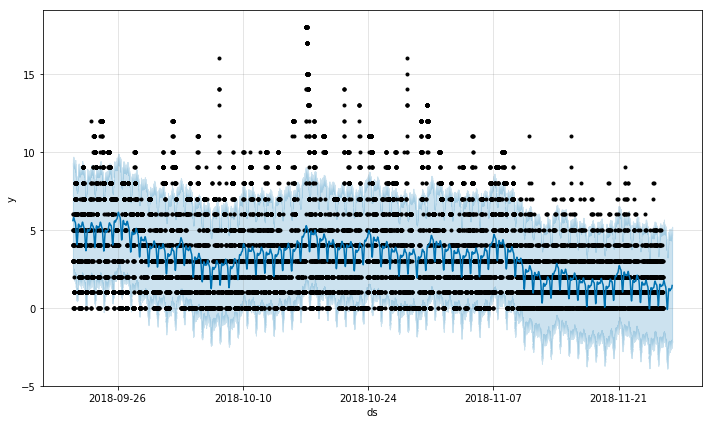

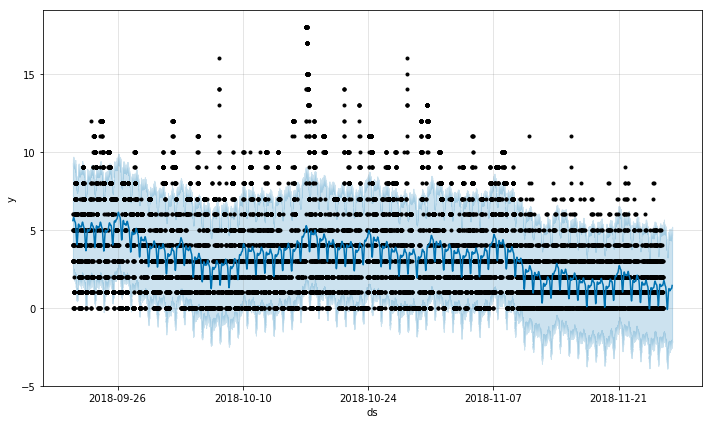

In [82]:
m.plot(forecast)

In [72]:
def make_comparison_dataframe(historical, forecast):
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))


In [87]:
cmp_df = make_comparison_dataframe(dft, forecast)
cmp_df.tail(120)

,yhat,yhat_lower,yhat_upper,y
ds,,,,
2018-11-26 14:00:00,1.001132,-2.537819,4.534002,1
2018-11-26 14:05:00,1.029084,-2.499813,4.446747,1
2018-11-26 14:10:00,1.055350,-2.566516,4.728069,1
2018-11-26 14:15:00,1.079882,-2.543276,4.419133,1
2018-11-26 14:20:00,1.102642,-2.596383,4.354510,0
2018-11-26 14:25:00,1.123602,-2.134583,4.872226,1
2018-11-26 14:30:00,1.142748,-2.467906,4.686503,3
2018-11-26 14:35:00,1.160073,-2.461436,4.807001,2
2018-11-26 14:40:00,1.175583,-2.430464,4.747870,2


In [76]:
def calculate_forecast_errors(df, prediction_size):
    
    df = df.copy()
    
    df['e'] = df['y'] - df['yhat']
    df['p'] = 100 * df['e'] / df['y']
    
    predicted_part = df[-prediction_size:]
    
    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))
    
    return {'MAPE': error_mean('p'), 'MAE': error_mean('e')}

In [88]:
for err_name, err_value in calculate_forecast_errors(cmp_df, prediction_size).items():
    print(err_name, err_value)

MAE 0.9625374540653969
MAPE inf


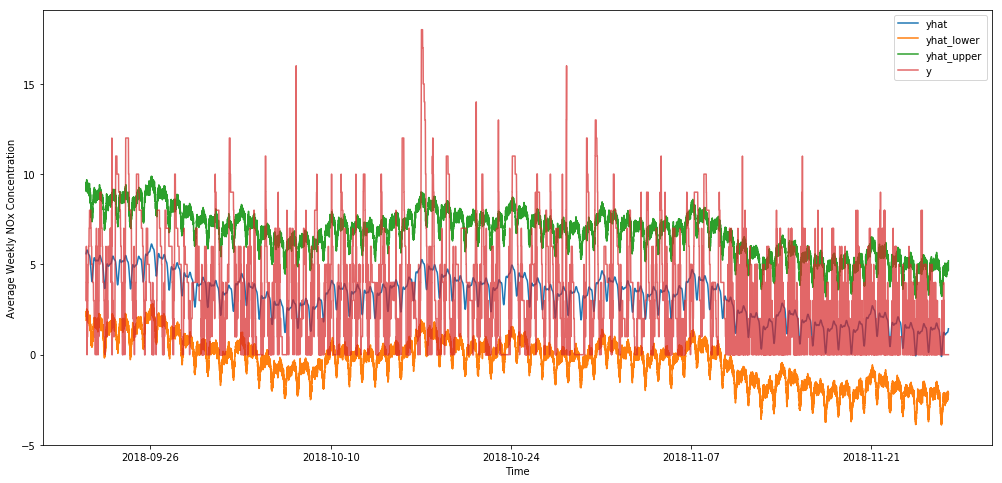

In [91]:
plt.figure(figsize=(17, 8))
plt.plot(cmp_df['yhat'])
plt.plot(cmp_df['yhat_lower'])
plt.plot(cmp_df['yhat_upper'])
plt.plot(cmp_df['y'],alpha=0.7)
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Average Weekly NOx Concentration')
plt.grid(False)
plt.show()